In [1]:
import random

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from algorithm_gd import get_iteration_vs_accuracy_data

In [4]:
no_of_nodes = 3

In [5]:
# actual_m = 10
# actual_c = 20

x = [1, 1, 1, 2, 2, 2, 3, 3, 3,  5, 5, 5, 6, 6, 6, 7,7, 7,  9, 9, 9, 10, 10, 10, 11, 11, 11]
y = [2, 2.25, 1.75, 2, 2.25, 1.75, 2, 2.25, 1.75, 6, 6.25, 5.75, 6, 6.25, 5.75, 6, 6.25, 5.75,  10, 9.75, 10.25, 10, 9.75, 10.25, 10, 9.75, 10.25]
# y

Text(0, 0.5, 'Y')

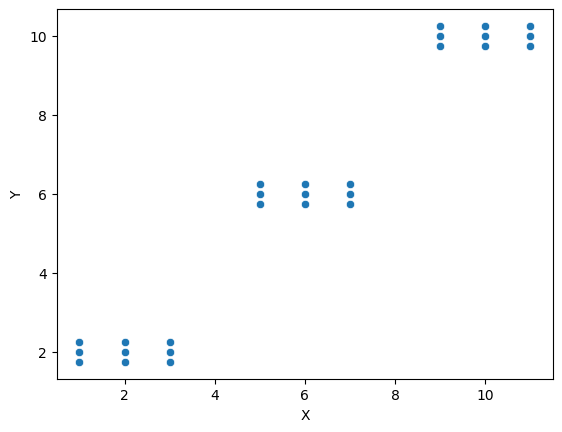

In [6]:
ax = sns.scatterplot(x=x, y=y)
ax.set_xlabel("X")
ax.set_ylabel("Y")

In [7]:
N = len(x) // no_of_nodes
N

9

In [8]:
def gen_test_data_partition(partitions, data):
    data_cp = data.copy()
    random.shuffle(data_cp)
    n = len(data_cp) // partitions
    result = []
    for i in range(partitions):
        result.append(data_cp[i*n:(i+1)*n])
    return result

In [9]:
node_data = []
node_test_samples = [{'x': [], 'y': []} for i in range(no_of_nodes)]
for i in range(no_of_nodes):
    X = x[i*N:(i+1)*N]
    Y = y[i*N:(i+1)*N]
    node_data.append({"x": X, "y": Y})
    node_data[-1]["y_mean"] = sum(node_data[-1]["y"])/len(node_data[-1]["y"])
    test_samples = gen_test_data_partition(no_of_nodes, list(zip(X, Y)))
    for j, node_test_sample in enumerate(test_samples):
        for test_sample in node_test_sample:
            node_test_samples[j]['x'].append(test_sample[0])
            node_test_samples[j]['y'].append(test_sample[1])

for i in range(no_of_nodes):
    node_test_samples[i]['y_mean'] = sum(node_test_samples[i]["y"])/len(node_test_samples[i]["y"])

# node_data, node_test_samples

In [10]:
node_params = [ {"m": 0, "c": 0} for i in range(no_of_nodes)]
node_params

[{'m': 0, 'c': 0}, {'m': 0, 'c': 0}, {'m': 0, 'c': 0}]

In [11]:
iterations = 1000

In [12]:
L = 0.0001 # learning rate

In [13]:
def forward_node(node_id, X):
    params = node_params[node_id]
    # x = node_data[node_id]["x"]
    return [params["m"] * i + params["c"] for i in X]

In [14]:
def loss_fn_node(y_actual, y_pred):
    # y = node_data[node_id]["y"]
    return (1 / N) * sum( (y_actual[i] - y_pred[i]) ** 2 for i in range(N) )

In [15]:
def r2_score_node(y_actual, y_actual_mean, y_pred):
    # y = node_data[node_id]["y"]
    # y_mean = node_data[node_id]["y_mean"]
    rss = sum( (y_actual[i] - y_pred[i])**2 for i in range(N) )
    tss = sum( (y_actual[i] - y_actual_mean)**2 for i in range(N) )
    r2 = 1 - rss/tss
    return r2

In [16]:
def gradient_m_node(node_id, y_pred):
    x = node_data[node_id]["x"]
    y = node_data[node_id]["y"]
    return (-2 / N) * sum( ( x[i] * (y[i] - y_pred[i]) ) for i in range(N) )

In [17]:
def gradient_c_node(node_id, y_pred):
    y = node_data[node_id]["y"]
    return (-2 / N) * sum( (y[i] - y_pred[i]) for i in range(N) )

In [18]:
doubly_stochastic_matrix_config = [
    [1/2, 1/4, 1/4],
    [1/4, 0, 3/4],
    [1/4, 3/4, 0]
]

doubly_stochastic_matrix_config = [
    [2/3, 1/6, 1/6],
    [1/6, 1/6, 2/3],
    [1/6, 2/3, 1/6]
]

In [19]:
# doubly_stochastic_matrix_config = [
#     [1/3, 1/3, 1/3],
#     [1/3, 1/3, 1/3],
#     [1/3, 1/3, 1/3]
# ]

In [20]:
# for i in range(iterations):
#     for node_id in range(no_of_nodes):
#         y_pred = forward_node(node_id)
#         loss = loss_fn_node(node_id, y_pred)
#         accuracy = r2_score_node(node_id, y_pred)
#         print("Node:", node_id, "| Loss:", round(loss, 6), "| Accuracy:", round(accuracy, 6))
    
#         grad_m = gradient_m_node(node_id, y_pred)
#         grad_c = gradient_c_node(node_id, y_pred)
#         # print("gradient of m:", grad_m, "| graident of c:", grad_c)

#         params = node_params[node_id]
#         params['m'] = params['m'] - L * grad_m
#         params['c'] = params['c'] - L * grad_c
#         # print(params)
#         # print()

#     # comm and averaging
#     node_params_copy = node_params.copy()
#     for node_id in range(no_of_nodes):
#         doubly_st_mt = doubly_stochastic_matrix_config[node_id]
#         node_params[node_id]["m"] = sum( frac*node_params_copy[i]["m"] for i, frac in enumerate(doubly_st_mt) )
#         node_params[node_id]["c"] = sum( frac*node_params_copy[i]["c"] for i, frac in enumerate(doubly_st_mt) )

#     print(node_params)

In [21]:
steps_data = []
accuracy_data = [
    [] for i in range(no_of_nodes)
]

In [22]:
for i in range(1, iterations+1):
    gradients = []
    steps_data.append(i)
    for node_id in range(no_of_nodes):
        X_actual = node_data[node_id]["x"]

        X_test = node_test_samples[node_id]["x"]
        y_test = node_test_samples[node_id]["y"]
        y_test_mean = node_test_samples[node_id]["y_mean"]
    
        y_test_pred = forward_node(node_id, X_test)
        y_actual_pred = forward_node(node_id, X_actual)
        
        loss = loss_fn_node(y_test, y_test_pred)
        accuracy = r2_score_node(y_test, y_test_mean, y_test_pred)

        accuracy_data[node_id].append(accuracy)
        # print("Node:", node_id, "| Loss:", round(loss, 6), "| Accuracy:", round(accuracy, 6))
    
        grad_m = gradient_m_node(node_id, y_actual_pred)
        grad_c = gradient_c_node(node_id, y_actual_pred)
        # print("gradient of m:", grad_m, "| graident of c:", grad_c)

        gradients.append({"m": grad_m, "c": grad_c})
        # print(params)
        # print()

    # comm and averaging
    for node_id in range(no_of_nodes):
        doubly_st_mt = doubly_stochastic_matrix_config[node_id]
        params = node_params[node_id]
        grad_m = sum( frac*gradients[i]["m"] for i, frac in enumerate(doubly_st_mt) )
        grad_c = sum( frac*gradients[i]["c"] for i, frac in enumerate(doubly_st_mt) )
        params['m'] = params['m'] - L * grad_m
        params['c'] = params['c'] - L * grad_c

    gradients = []
    # print(node_params)

In [23]:
gd_iterations, gd_accuracy = get_iteration_vs_accuracy_data(x, y, iterations, L=L)

<Axes: title={'center': 'Iteration vs Accuracy (1000 iterations)'}, xlabel='Iteration', ylabel='Accuracy'>

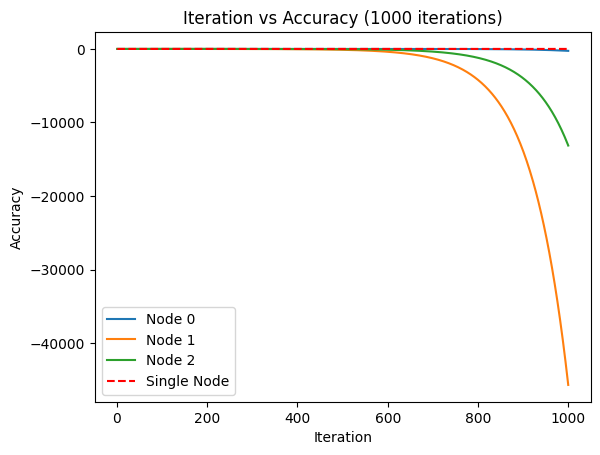

In [24]:
data = {f'Node {i}': accuracy_data[i] for i in range(no_of_nodes)}
df = pd.DataFrame({"Iteration": steps_data, **data})
dfl = pd.melt(df, ["Iteration"], value_name="Accuracy", var_name="Node")
ax = sns.lineplot(data=dfl, x='Iteration', y='Accuracy', hue='Node')
ax.set_title(f"Iteration vs Accuracy ({iterations} iterations)")
sns.lineplot(x=gd_iterations, y=gd_accuracy, linestyle='--', color='r', label='Single Node')

<Axes: title={'center': 'Iteration vs Accuracy (200 iterations)'}, xlabel='Iteration', ylabel='Accuracy'>

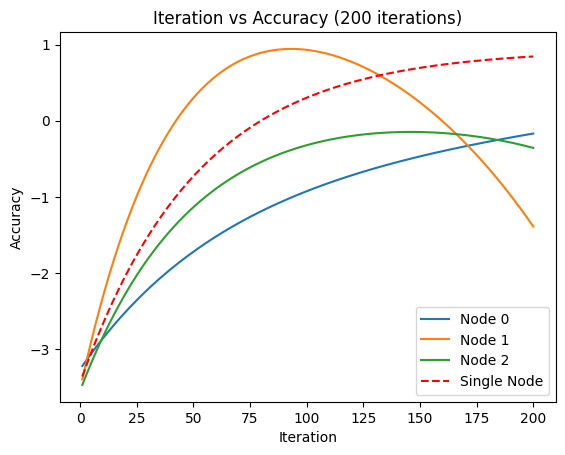

In [29]:
iterations_sample = 200
data = {f'Node {i}': accuracy_data[i][:iterations_sample] for i in range(no_of_nodes)}
df = pd.DataFrame({"Iteration": steps_data[:iterations_sample], **data})
dfl = pd.melt(df, ["Iteration"], value_name="Accuracy", var_name="Node")

ax = sns.lineplot(data=dfl, x='Iteration', y='Accuracy', hue='Node')
ax.set_title(f"Iteration vs Accuracy ({iterations_sample} iterations)")

sns.lineplot(x=gd_iterations[:iterations_sample], y=gd_accuracy[:iterations_sample], linestyle='--', color='r', label='Single Node')

Text(0.5, 1.0, 'Iteration vs Accuracy (1000 iterations) - Gradient descent in single node')

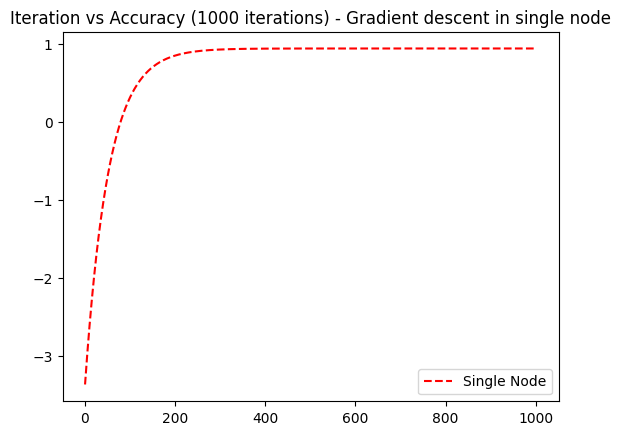

In [26]:
ax = sns.lineplot(x=gd_iterations, y=gd_accuracy, linestyle='--', color='r', label='Single Node')
ax.set_title(f"Iteration vs Accuracy ({iterations} iterations) - Gradient descent in single node")